In [6]:
%matplotlib widget
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
dataM1 = pd.read_csv("GBPUSD_M1.csv")
dataM1['Time'] = pd.to_datetime(dataM1['Time'])

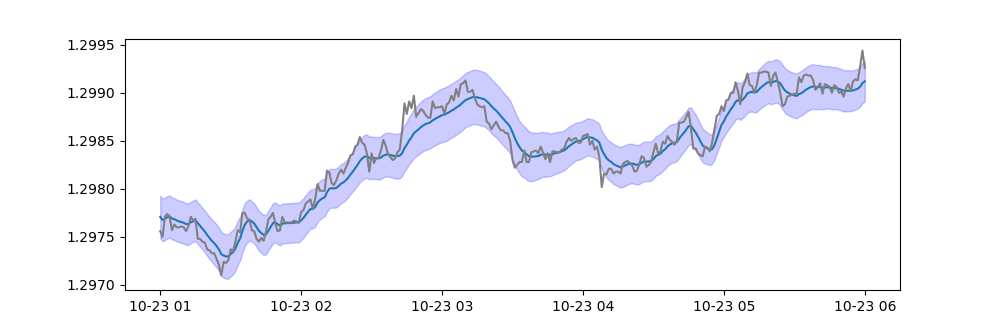

In [19]:
plt.clf()

time_arr = dataM1['Time'].values.astype('datetime64[ms]')
close_arr = dataM1['Close'].values

study_start = np.datetime64("2024-10-23T01:00")
start_index = np.searchsorted(time_arr, study_start)
study_length = 5 * 60

kernel = Matern(length_scale=1.0, nu=1.5)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1, n_restarts_optimizer=0, normalize_y=True)

window_size = 100
X = np.arange(window_size + 1)[:, None]
total_points = study_length + 1

y_preds = np.empty(total_points)
std_preds = np.empty(total_points)
time_preds = np.empty(total_points, dtype='datetime64[ms]')

for i in range(total_points):
    window_slice = slice(start_index - window_size + i, start_index + 1 + i)
    y = close_arr[window_slice].reshape(-1, 1)
    
    gpr.fit(X, y)
    y_pred, std = gpr.predict([[window_size]], return_std=True)
    
    y_preds[i] = y_pred.item()
    std_preds[i] = std.item()
    time_preds[i] = time_arr[start_index + i]
    

plt.plot(time_preds, y_preds)
plt.fill_between(time_preds, 
                y_preds - 1.96 * std_preds,
                y_preds + 1.96 * std_preds,
                alpha=0.2, color='blue')

plt.plot(time_arr[start_index:start_index+study_length+1], 
         close_arr[start_index:start_index+study_length+1], color='gray')
plt.show()



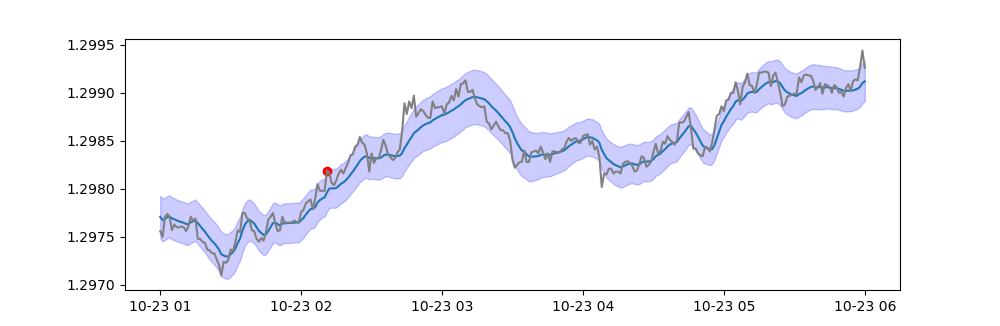

In [ ]:
plt.clf()

plt.plot(time_preds, y_preds)
plt.fill_between(time_preds, 
                y_preds - 1.96 * std_preds,
                y_preds + 1.96 * std_preds,
                alpha=0.2, color='blue')

plt.plot(time_arr[start_index:start_index+study_length+1], 
         close_arr[start_index:start_index+study_length+1], color='gray')


i = start_index
pos = 'none'
while i <= start_index+study_length:
    
    if pos == 'none' and close_arr[i] < (y_preds[i-start_index]- 1.96 * std_preds[i-start_index]):
        pos = 'buy'
        plt.scatter(time_arr[i],close_arr[i], color='green')
        i += 1
        continue

    if pos == 'none' and close_arr[i] > (y_preds[i-start_index]+ 1.96 * std_preds[i-start_index]):
        pos = 'sell'
        plt.scatter(time_arr[i],close_arr[i], color='red')
        i += 1
        continue

    if pos == 'buy' and close_arr[i] >= y_preds[i-start_index]:
        continue

    i += 1



plt.show()